In [12]:
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.0 MB/s eta 0:00:0000:010:01


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

CONN = "СЕКРЕТ😊"

## Users

In [2]:
# users = pd.read_sql(
#     """SELECT * FROM public.user_data""",
#     con=CONN
# )

users = pd.read_csv("/kaggle/input/recsysproject/users.csv")
users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [3]:
users.shape

(163205, 8)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


## Posts

In [5]:
# posts = pd.read_sql(
#     """SELECT * FROM public.post_text_df""",
#     con=CONN
#     )

posts = pd.read_csv("/kaggle/input/recsysproject/posts.csv")
posts.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [6]:
posts.shape

(7023, 3)

In [7]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


## Interactions

In [8]:
# interactions = pd.read_sql(
#     """SELECT * FROM public.feed_data LIMIT 1000000""",
#     con=CONN
#     )

interactions = pd.read_csv("/kaggle/input/recsysproject/interactions.csv")
interactions.head()

,timestamp,user_id,post_id,action,target
0,2021-10-13 11:24:39,67929,4887,view,0
1,2021-10-13 11:27:18,67929,6510,view,0
2,2021-10-13 11:29:22,67929,4833,view,1
3,2021-10-13 11:31:56,67929,4833,like,0
4,2021-10-13 11:31:58,67929,5199,view,0


If user liked some post, then there are 2 samples of the same (user_id, post_id) key. In the 1st one action=view, target=1; in the 2nd one action=like, targer=0. Example:
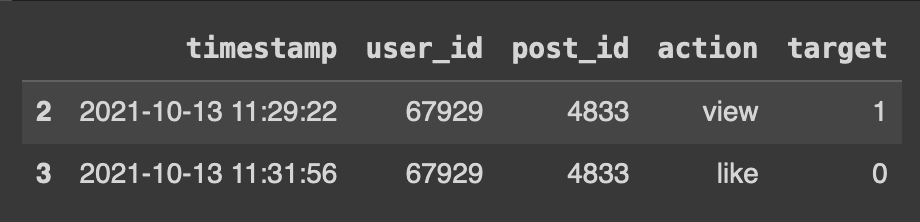

Therefore we should drop all "like" actions

In [9]:
interactions = interactions[interactions["action"] == "view"]

In [10]:
interactions.shape

(893762, 5)

## TF-IDF

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

nlp = spacy.load('en_core_web_sm')


def preprocess_text(text):
    # Lowering words and filtering
    # Lemmatization
    text = text.replace('\n', ' ')
    doc = nlp(text.lower())
    lemmatized_words = [token.lemma_ for token in doc if token.text not in punctuation and token.text not in stop_words]
    lemmatized_words = ' '.join(lemmatized_words)
    return lemmatized_words


tfidf = TfidfVectorizer(preprocessor=preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tfidf_posts = tfidf.fit_transform(posts['text'])
tfidf_posts = tfidf_posts.toarray()

tfidf_posts.shape

(7023, 42916)

In [ ]:
tfidf_posts = pd.DataFrame(
    tfidf_posts,
    index=posts.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_posts.head()

,00,000,0001,000bn,000s,000th,001,001and,001st,002,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.131925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimention reduction

In [ ]:
# Centering the data
centered_posts = tfidf_posts.subtract(tfidf_posts.mean())

centered_posts.head()

,00,000,0001,000bn,000s,000th,001,001and,001st,002,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,-0.000508,-0.004742,-0.000009,-0.000015,-0.000032,-0.000067,-0.000019,-0.000009,-0.000016,-0.000056,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
2,-0.000508,0.127183,-0.000009,-0.000015,-0.000032,-0.000067,-0.000019,-0.000009,-0.000016,-0.000056,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
3,-0.000508,0.045601,-0.000009,-0.000015,-0.000032,-0.000067,-0.000019,-0.000009,-0.000016,-0.000056,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
4,-0.000508,-0.004742,-0.000009,-0.000015,-0.000032,-0.000067,-0.000019,-0.000009,-0.000016,-0.000056,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003
5,-0.000508,-0.004742,-0.000009,-0.000015,-0.000032,-0.000067,-0.000019,-0.000009,-0.000016,-0.000056,...,-0.000059,-0.00003,-0.000059,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003,-0.00003


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
decomposed_posts = pca.fit_transform(centered_posts)

decomposed_posts = pd.DataFrame(decomposed_posts)

decomposed_posts.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.039160,0.187715,-0.022370,-0.107974,-0.149832,-0.208312,-0.149728,-0.128914,0.014317,-0.060362,...,-0.011992,-0.020124,0.023044,0.019315,0.009942,-0.011597,-0.019642,0.007121,0.042481,0.003419
1,-0.030204,0.202089,0.067235,0.030381,-0.030804,-0.036297,0.013561,-0.020409,-0.006858,0.008842,...,0.002767,-0.064021,0.004536,0.013435,-0.038955,0.023462,0.003758,0.031223,-0.007894,-0.020741
2,-0.028143,0.146029,-0.027967,-0.102500,-0.152342,-0.146390,-0.103888,-0.010123,-0.011719,-0.004960,...,0.031490,-0.089881,0.005556,-0.074994,-0.042054,0.044519,0.011132,0.004153,0.041765,0.018357
3,-0.057124,0.125778,-0.008569,-0.062654,-0.113217,-0.065081,-0.020657,0.049250,-0.021696,0.022055,...,-0.019973,0.010316,0.019661,-0.001397,0.041667,-0.011374,0.017241,0.024026,0.054035,-0.010990
4,-0.039287,0.084903,-0.012771,-0.035143,-0.048843,-0.023550,0.027105,0.067875,0.001907,0.015052,...,-0.009003,-0.026886,0.016133,-0.009865,0.028119,-0.015013,-0.013193,0.028157,-0.024744,0.015260


In [ ]:
# Rename features

columns = [f"PCA_{i}" for i in range(decomposed_posts.shape[1])]

preprocessed_posts = decomposed_posts.copy()
preprocessed_posts.columns = columns

preprocessed_posts.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_90,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99
0,-0.039160,0.187715,-0.022370,-0.107974,-0.149832,-0.208312,-0.149728,-0.128914,0.014317,-0.060362,...,-0.011992,-0.020124,0.023044,0.019315,0.009942,-0.011597,-0.019642,0.007121,0.042481,0.003419
1,-0.030204,0.202089,0.067235,0.030381,-0.030804,-0.036297,0.013561,-0.020409,-0.006858,0.008842,...,0.002767,-0.064021,0.004536,0.013435,-0.038955,0.023462,0.003758,0.031223,-0.007894,-0.020741
2,-0.028143,0.146029,-0.027967,-0.102500,-0.152342,-0.146390,-0.103888,-0.010123,-0.011719,-0.004960,...,0.031490,-0.089881,0.005556,-0.074994,-0.042054,0.044519,0.011132,0.004153,0.041765,0.018357
3,-0.057124,0.125778,-0.008569,-0.062654,-0.113217,-0.065081,-0.020657,0.049250,-0.021696,0.022055,...,-0.019973,0.010316,0.019661,-0.001397,0.041667,-0.011374,0.017241,0.024026,0.054035,-0.010990
4,-0.039287,0.084903,-0.012771,-0.035143,-0.048843,-0.023550,0.027105,0.067875,0.001907,0.015052,...,-0.009003,-0.026886,0.016133,-0.009865,0.028119,-0.015013,-0.013193,0.028157,-0.024744,0.015260


## Data merging

In [14]:
posts_info = posts.join(preprocessed_posts)


df = pd.merge(
    users, interactions,
    on='user_id',
    how='right'
)

df = pd.merge(
    df, posts_info,
    on='post_id',
    how='left'
)


# df = df.set_index(['user_id', 'post_id'])

df.head()

gender  age country     city  exp_group   os source  \
user_id post_id                                                        
67929   4887          1   20  Russia  Noginsk          4  iOS    ads   
        6510          1   20  Russia  Noginsk          4  iOS    ads   
        4833          1   20  Russia  Noginsk          4  iOS    ads   
        5199          1   20  Russia  Noginsk          4  iOS    ads   
        2148          1   20  Russia  Noginsk          4  iOS    ads   

                           timestamp action  target  ...    PCA_90    PCA_91  \
user_id post_id                                      ...                       
67929   4887     2021-10-13 11:24:39   view       0  ... -0.022718 -0.007469   
        6510     2021-10-13 11:27:18   view       0  ... -0.008186  0.005035   
        4833     2021-10-13 11:29:22   view       1  ... -0.013597 -0.002052   
        5199     2021-10-13 11:31:58   view       0  ...  0.021062 -0.036481   
        2148     2021-10-13 11:34:04   view       0  ...  0.016000 -0.005580   

                   PCA_92    PCA_93    PCA_94    PCA_95    PCA_96    PCA_97  \
user_id post_id                                                               
67929   4887     0.000720 -0.001640 -0.020607  0.014177 -0.020029 -0.028250   
        6510    -0.005618 -0.025965 -0.009683  0.011373 -0.010202 -0.018200   
        4833     0.001951 -0.025460 -0.011670  0.011078 -0.005315  0.015610   
        5199    -0.036037  0.006219  0.020088  0.032606 -0.014776 -0.028191   
        2148    -0.067959 -0.027237  0.015694 -0.015247 -0.023886  0.021738   

                   PCA_98    PCA_99  
user_id post_id                      
67929   4887     0.013725 -0.044036  
        6510     0.005860 -0.020700  
        4833     0.021721  0.002008  
        5199    -0.008260 -0.065428  
        2148     0.000073 -0.020679  

[5 rows x 112 columns]

In [ ]:
posts_info.to_sql(
    "proxyislegend_posts_info_features",
    con=CONN,
    schema="public",
    if_exists='replace',
    index=False
   )

49

In [14]:
posts_info = pd.read_sql(
    """SELECT * FROM public.proxyislegend_posts_info_features""",
    con=CONN
)

df = pd.merge(
    users, interactions,
    on='user_id',
    how='right'
)

df = pd.merge(
    df, posts_info,
    on='post_id',
    how='left'
)

# df = df.set_index(['user_id', 'post_id'])

df.head()

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,...,PCA_90,PCA_91,PCA_92,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99
0,67929,1,20,Russia,Noginsk,4,iOS,ads,2021-10-13 11:24:39,4887,...,-0.022718,-0.007469,0.000720,-0.001640,-0.020607,0.014177,-0.020029,-0.028250,0.013725,-0.044036
1,67929,1,20,Russia,Noginsk,4,iOS,ads,2021-10-13 11:27:18,6510,...,-0.008186,0.005035,-0.005618,-0.025965,-0.009683,0.011373,-0.010202,-0.018200,0.005860,-0.020700
2,67929,1,20,Russia,Noginsk,4,iOS,ads,2021-10-13 11:29:22,4833,...,-0.013597,-0.002052,0.001951,-0.025460,-0.011670,0.011078,-0.005315,0.015610,0.021721,0.002008
3,67929,1,20,Russia,Noginsk,4,iOS,ads,2021-10-13 11:31:58,5199,...,0.021062,-0.036481,-0.036037,0.006219,0.020088,0.032606,-0.014776,-0.028191,-0.008260,-0.065428
4,67929,1,20,Russia,Noginsk,4,iOS,ads,2021-10-13 11:34:04,2148,...,0.016000,-0.005580,-0.067959,-0.027237,0.015694,-0.015247,-0.023886,0.021738,0.000073,-0.020679


In [15]:
df.sort_values('timestamp', inplace=True)

In [16]:
# Extract some features

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.weekday

In [17]:
for column in df.columns:
    if 'PCA' not in column:
        print(column)

user_id
gender
age
country
city
exp_group
os
source
timestamp
post_id
action
target
text
topic
hour
month
day_of_week


In [18]:
df.drop(columns=['action', 'text', 'topic', 'exp_group'], inplace=True)

## Model training

In [19]:
separation_date = df['timestamp'].quantile(q=0.8)
separation_date

Timestamp('2021-12-11 22:26:02')

In [20]:
train = df[df['timestamp'] < separation_date]
test = df[df['timestamp'] >= separation_date]

train.drop(columns=['timestamp'], inplace=True)
test.drop(columns=['timestamp'], inplace=True)

X_train, y_train = train.drop(columns=['target'], inplace=False), train['target']
X_test, y_test = test.drop(columns=['target'], inplace=False), test['target']

X_train

/tmp/ipykernel_34/734066760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=['timestamp'], inplace=True)
/tmp/ipykernel_34/734066760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['timestamp'], inplace=True)


,user_id,gender,age,country,city,os,source,post_id,PCA_0,PCA_1,...,PCA_93,PCA_94,PCA_95,PCA_96,PCA_97,PCA_98,PCA_99,hour,month,day_of_week
180430,62123,1,28,Russia,Moscow,Android,ads,7168,0.077642,-0.035384,...,0.000132,0.004077,0.005553,-0.024742,-0.006703,0.014169,-0.013225,6,10,4
326375,165744,1,27,Ukraine,Vremivka,Android,organic,4744,0.122327,-0.042787,...,0.019724,0.003046,-0.015311,0.021680,0.018663,-0.021667,-0.012585,6,10,4
326376,165744,1,27,Ukraine,Vremivka,Android,organic,662,-0.038581,0.085903,...,-0.039179,-0.070362,0.047098,0.009408,-0.015498,0.046972,0.008258,6,10,4
180431,62123,1,28,Russia,Moscow,Android,ads,2001,-0.013644,0.095100,...,-0.030832,-0.012461,0.016999,0.035399,-0.009569,-0.019339,0.004325,6,10,4
664657,36892,0,27,Russia,Tolyatti,Android,ads,2657,-0.136540,-0.040579,...,0.008563,0.021952,0.014120,0.001170,0.028885,0.000331,0.009150,6,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727119,36914,0,38,Russia,Domodedovo,Android,ads,1332,-0.016037,0.283372,...,-0.007474,0.041764,0.024472,0.032518,-0.057463,0.012511,-0.005506,22,12,5
571220,96346,1,24,Belarus,Minsk,Android,ads,3001,-0.120462,-0.053405,...,0.010601,-0.019494,-0.017769,0.007808,-0.008653,-0.017937,-0.000514,22,12,5
584518,31338,0,29,Russia,Barnaul,Android,ads,1748,0.017404,0.130268,...,0.029544,-0.012693,-0.015360,-0.037862,-0.083663,0.017491,0.058106,22,12,5
554445,102831,1,35,Russia,Krasnodar,Android,ads,1281,0.032618,0.281795,...,-0.011347,0.001416,-0.016566,0.008574,0.011845,-0.002131,-0.023821,22,12,5


In [21]:
df.select_dtypes(include=['object']).columns

Index(['country', 'city', 'os', 'source'], dtype='object')

In [22]:
!pip install catboost

In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

categorical_features = ['country', 'city', 'os', 'source', 'gender', 'hour', 'month', 'day_of_week']

In [28]:
default_catboost = CatBoostClassifier(task_type="GPU")

default_catboost.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.023485
0:	learn: 0.6743963	total: 259ms	remaining: 4m 18s
1:	learn: 0.6570624	total: 291ms	remaining: 2m 25s
2:	learn: 0.6404792	total: 353ms	remaining: 1m 57s
3:	learn: 0.6248470	total: 421ms	remaining: 1m 44s
4:	learn: 0.6100868	total: 484ms	remaining: 1m 36s
5:	learn: 0.5958932	total: 543ms	remaining: 1m 30s
6:	learn: 0.5826654	total: 600ms	remaining: 1m 25s
7:	learn: 0.5703052	total: 652ms	remaining: 1m 20s
8:	learn: 0.5585490	total: 678ms	remaining: 1m 14s
9:	learn: 0.5473256	total: 728ms	remaining: 1m 12s
10:	learn: 0.5361307	total: 783ms	remaining: 1m 10s
11:	learn: 0.5261326	total: 828ms	remaining: 1m 8s
12:	learn: 0.5166588	total: 874ms	remaining: 1m 6s
13:	learn: 0.5077037	total: 917ms	remaining: 1m 4s
14:	learn: 0.4992584	total: 983ms	remaining: 1m 4s
15:	learn: 0.4913807	total: 1.03s	remaining: 1m 3s
16:	learn: 0.4838944	total: 1.06s	remaining: 1m 1s
17:	learn: 0.4768335	total: 1.09s	remaining: 59.6s
18:	learn: 0.4700419	total: 1.14s	remaining: 58.8s


In [29]:
print(f"Train score: {roc_auc_score(y_train, default_catboost.predict_proba(X_train)[:, 1])}")
print(f"Test score: {roc_auc_score(y_test, default_catboost.predict_proba(X_test)[:, 1])}")

Train score: 0.7040030500753068
Test score: 0.6583365428813039


In [24]:
def plot_feature_importance(importance, names, model_type, number=10):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False)[:number]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

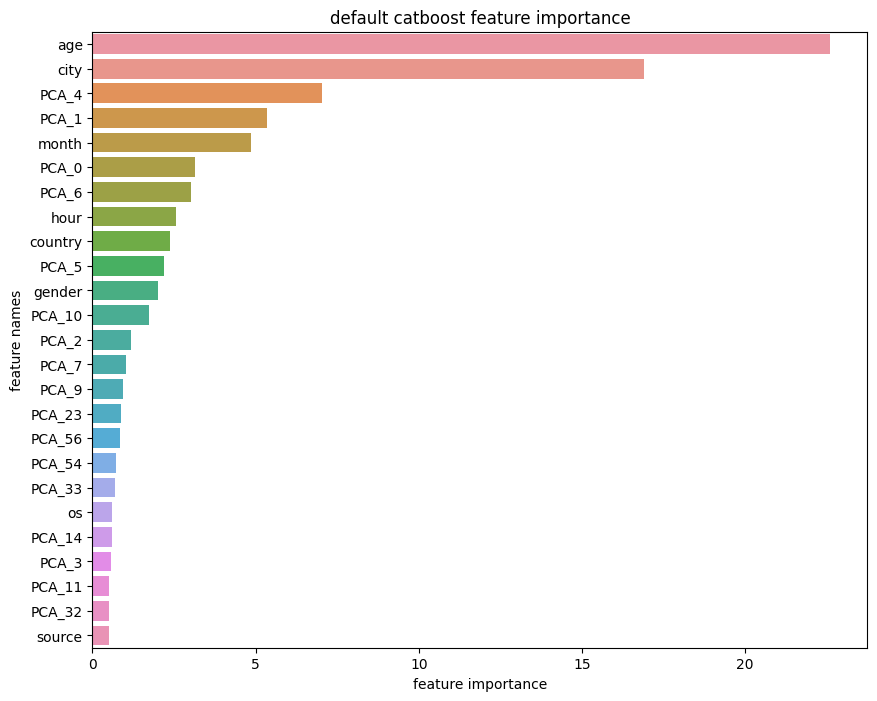

In [31]:
plot_feature_importance(default_catboost.get_feature_importance(), X_train.columns, 'default catboost', 25)

In [32]:
default_catboost.save_model('default_catboost_model', format="cbm")

## Hyperparameter tuning

In [25]:
!pip install optuna

In [26]:
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 2e-6, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Poisson", "Bernoulli", "MVS"]),
    }

    model = CatBoostClassifier(**params, silent=True, task_type="GPU")
    model.fit(X_train, y_train, cat_features=categorical_features)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    return roc_auc

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-09-05 18:45:00,344] A new study created in memory with name: no-name-795172d9-5f01-46d6-b715-80824ba22088
[I 2024-09-05 18:45:51,265] Trial 0 finished with value: 0.6443725632436168 and parameters: {'learning_rate': 0.006039149878850216, 'depth': 5, 'subsample': 0.44541843634541955, 'min_data_in_leaf': 90, 'bootstrap_type': 'Poisson'}. Best is trial 0 with value: 0.6443725632436168.
[I 2024-09-05 18:46:55,909] Trial 1 finished with value: 0.6159787772929012 and parameters: {'learning_rate': 0.0005626503838081586, 'depth': 7, 'subsample': 0.22750094067029802, 'min_data_in_leaf': 64, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6443725632436168.
[I 2024-09-05 18:53:33,826] Trial 2 finished with value: 0.6197964039391969 and parameters: {'learning_rate': 0.0001610733852244192, 'depth': 13, 'subsample': 0.34888257040410103, 'min_data_in_leaf': 75, 'bootstrap_type': 'Poisson'}. Best is trial 0 with value: 0.6443725632436168.
[I 2024-09-05 19:00:37,039] Trial 3 finis

In [28]:
print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)

Best hyperparameters: {'learning_rate': 0.040605608938078824, 'depth': 7, 'subsample': 0.9952162053509326, 'min_data_in_leaf': 12, 'bootstrap_type': 'Poisson'}
Best score: 0.6653217141403824


Best hyperparameters: {'learning_rate': 0.040605608938078824, 'depth': 7, 'subsample': 0.9952162053509326, 'min_data_in_leaf': 12, 'bootstrap_type': 'Poisson'}<br>
Best score: 0.6653217141403824

In [29]:
tuned_catboost = CatBoostClassifier(iterations=1000, **study.best_params, task_type="GPU")

tuned_catboost.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 0.6612410	total: 89.3ms	remaining: 1m 29s
1:	learn: 0.6328222	total: 158ms	remaining: 1m 19s
2:	learn: 0.6064472	total: 248ms	remaining: 1m 22s
3:	learn: 0.5815941	total: 316ms	remaining: 1m 18s
4:	learn: 0.5600423	total: 387ms	remaining: 1m 16s
5:	learn: 0.5406092	total: 448ms	remaining: 1m 14s
6:	learn: 0.5229326	total: 509ms	remaining: 1m 12s
7:	learn: 0.5067475	total: 572ms	remaining: 1m 10s
8:	learn: 0.4913971	total: 633ms	remaining: 1m 9s
9:	learn: 0.4782442	total: 696ms	remaining: 1m 8s
10:	learn: 0.4658700	total: 758ms	remaining: 1m 8s
11:	learn: 0.4549590	total: 819ms	remaining: 1m 7s
12:	learn: 0.4450920	total: 882ms	remaining: 1m 6s
13:	learn: 0.4364508	total: 915ms	remaining: 1m 4s
14:	learn: 0.4281615	total: 980ms	remaining: 1m 4s
15:	learn: 0.4208753	total: 1.04s	remaining: 1m 4s
16:	learn: 0.4140552	total: 1.1s	remaining: 1m 3s
17:	learn: 0.4082593	total: 1.14s	remaining: 1m 2s
18:	learn: 0.4022602	total: 1.21s	remaining: 1m 2s
19:	learn: 0.3968130	total: 1.27s

In [30]:
print(f"Train score: {roc_auc_score(y_train, tuned_catboost.predict_proba(X_train)[:, 1])}")
print(f"Test score: {roc_auc_score(y_test, tuned_catboost.predict_proba(X_test)[:, 1])}")

Train score: 0.7290063458984029
Test score: 0.6654790734891932


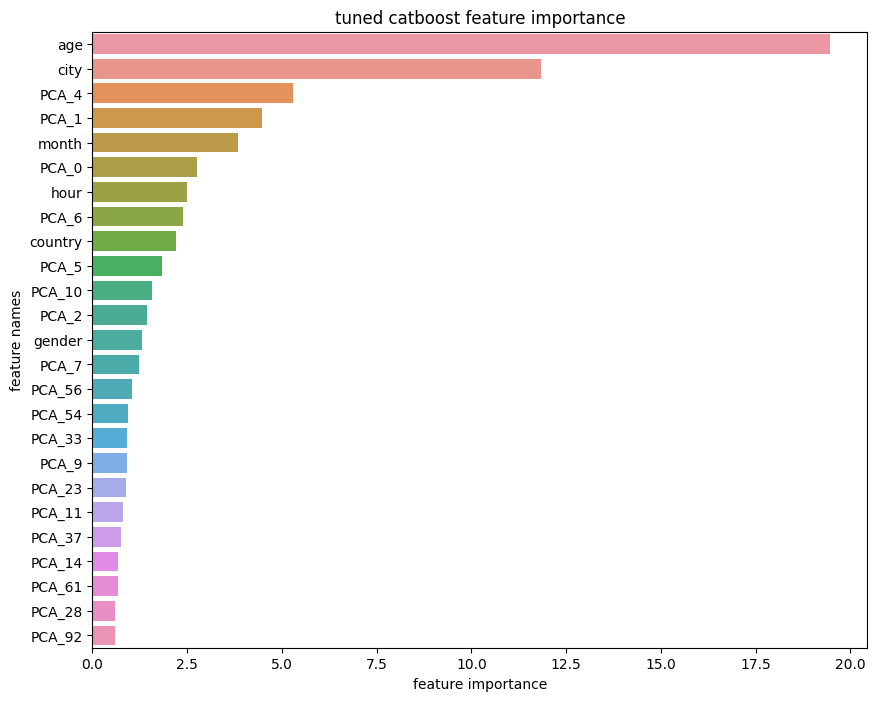

In [31]:
plot_feature_importance(tuned_catboost.get_feature_importance(), X_train.columns, 'tuned catboost', 25)

In [32]:
tuned_catboost.save_model('tuned_catboost_model', format="cbm")